In [1]:
import json
import collections
import os


from src.utils.metric_utils import compute_disentangle_score, compute_disentangle_scores_possible_empties


REPO_DIR = f"/workspace/ravel"
SRC_DIR = os.path.join(REPO_DIR, "src")
MODEL_DIR = os.path.join(REPO_DIR, "models")
DATA_DIR = os.path.join(REPO_DIR, "data")

entity_type = 'city'
target_attribute = 'Country'
split_type = 'context'
split_suffix = '-test'
model_name = 'tinyllama'


split_to_raw_example = json.load(
    open(os.path.join(DATA_DIR, model_name, f'{model_name}_{entity_type}_{split_type}_test.json')))
attribute_to_prompts = json.load(
    open(os.path.join(DATA_DIR, 'base', f'ravel_{entity_type}_attribute_to_prompts.json')))


attribute_to_iso_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a != target_attribute}
attribute_to_cause_tasks = {
    a: [p + split_suffix for p in ps if p + split_suffix in split_to_raw_example]
    for a, ps in attribute_to_prompts.items() if a == target_attribute}

print(attribute_to_iso_tasks)

for key in attribute_to_iso_tasks:
  print(key)

for key in attribute_to_cause_tasks:
  print(key, "Cause")

{'Continent': [' "language": "English"}, {"city": "%s", "continent": "-test', '[{"city": "Los Angeles", "continent": "North America"}, {"city": "%s", "continent": "-test', 'city: %s, continent:-test'], 'Latitude': ['[{"city": "Paris", "lat": "48.9"}, {"city": "%s", "lat": "-test', '[{"city": "Paris", "lat": "49"}, {"city": "%s", "lat": "-test', '[{"city": "St. Petersburg", "lat": "59.9"}, {"city": "%s", "lat": "-test', '[{"city": "Tokyo", "lat": "36"}, {"city": "%s", "lat": "-test', 'city: %s, latitude: (-test'], 'Longitude': [' "lat": "37.7749° N"}, {"city": "%s", "long": "-test', '[{"city": "Kuala Lumpur", "long": "101.7"}, {"city": "%s", "long": "-test', '[{"city": "San Francisco", "long": "122.4"}, {"city": "%s", "long": "-test', 'city: %s, longitude: -test'], 'Language': [' "continent": "Asia"}, {"city": "%s", "language": "-test', 'People in Beijing speak Chinese. People in %s speak-test', 'People in Hong Kong speak Chinese, English. People in %s speak-test', "The city of %s's gov

In [2]:

# gemma_dimension_to_log_path = {
#     'SAE': {d: f'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k_dim{d}_3tok_Country.json'
#             # Update the following dimensions to match your own results.
#             # SAE might have different feature dimensions from run to run due to
#             # randomness in the feature selection algorithm.
#             for d in [71, 325, 399, 536, 8192]
#     },
    # 'DAS': {d: f'tinyllama-layer14-dim{d}-baseline_daslora_3tok_Country_len48_pose_ep3_cause20000_evalall.json'
    #         for d in [16, 64]},
    # 'MDAS': {d: f'tinyllama-layer14-dim{d}-multitask_daslora_3tok_Country1_ex_Continent+Latitude+Longitude+Language+Timezone_len48_pose_ep3_cause20000_iso4000_evalall.json'
    #          for d in [16, 64]
    # },
# }
# tinyllama_dimension_to_log_path['RandomSAE'] = {
#             64: f'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k_random_dim64_3tok_Country.json',
#             512: f'tinyllama-layer14-dim8192-reg0.5-ep5-sae-city_wikipedia_200k_random_dim512_3tok_Country.json'
#             }

gemma_dimension_to_log_path = {"SAE": {}}

layer10_folders = []

for folder in os.listdir(MODEL_DIR):
    if folder.startswith("layer10"):
        layer10_folders.append(folder)
        gemma_dimension_to_log_path["SAE"][folder] = {}

for folder in layer10_folders:
    for file in os.listdir(os.path.join(MODEL_DIR, folder)):
        if file.endswith(".json") and "random" not in file and "dataset_size_120.json" in file:
            with open(os.path.join(MODEL_DIR, folder, file)) as f:
                data = json.load(f)
                gemma_dimension_to_log_path["SAE"][folder][file] = data
            

method_to_data = {}
for method in gemma_dimension_to_log_path:
    method_to_data[method] = {}
    for folder in gemma_dimension_to_log_path[method]:
        method_to_data[method][folder] = {}
        for json_filename in gemma_dimension_to_log_path[method][folder]:
            log_data = gemma_dimension_to_log_path[method][folder][json_filename]

            print(log_data['hyperparameters'].keys())
            print(len(log_data['hyperparameters']['inv_dims']))
            inv_dims = len(log_data['hyperparameters']['inv_dims'])
            del log_data['hyperparameters']

            method_to_data[method][folder][inv_dims] = compute_disentangle_scores_possible_empties(
                log_data, attribute_to_iso_tasks, attribute_to_cause_tasks)


dict_keys(['l0', 'layer_idx', 'inv_name', 'inv_dims'])
16384
Attribute to iso tasks: {'Continent': [' "language": "English"}, {"city": "%s", "continent": "-test', '[{"city": "Los Angeles", "continent": "North America"}, {"city": "%s", "continent": "-test', 'city: %s, continent:-test'], 'Latitude': ['[{"city": "Paris", "lat": "48.9"}, {"city": "%s", "lat": "-test', '[{"city": "Paris", "lat": "49"}, {"city": "%s", "lat": "-test', '[{"city": "St. Petersburg", "lat": "59.9"}, {"city": "%s", "lat": "-test', '[{"city": "Tokyo", "lat": "36"}, {"city": "%s", "lat": "-test', 'city: %s, latitude: (-test'], 'Longitude': [' "lat": "37.7749° N"}, {"city": "%s", "long": "-test', '[{"city": "Kuala Lumpur", "long": "101.7"}, {"city": "%s", "long": "-test', '[{"city": "San Francisco", "long": "122.4"}, {"city": "%s", "long": "-test', 'city: %s, longitude: -test'], 'Language': [' "continent": "Asia"}, {"city": "%s", "language": "-test', 'People in Beijing speak Chinese. People in %s speak-test', 'People

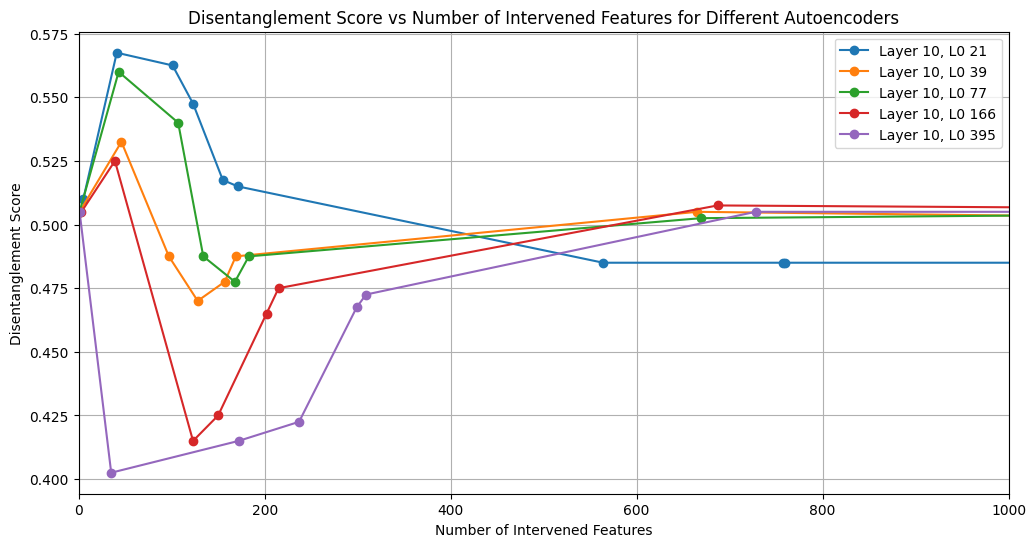

In [3]:
import matplotlib.pyplot as plt

def format_folder_name(folder):
    parts = folder.split('_')
    layer = parts[0].replace('layer', 'Layer ')
    l0 = parts[1].replace('l0', 'L0 ')
    return f"{layer}, {l0}"

# Assuming method_to_data is already populated as described
method = "SAE"  # Since you mentioned there's only one key
metric = "disentangle"
# metric = "isolate"
# metric = "cause"

# Prepare data for plotting
folders = method_to_data[method].keys()
plot_data = {folder: {'inv_dims': [], metric: []} for folder in folders}

for folder in folders:
    # Convert items to a list and sort by inv_dims
    sorted_items = sorted(method_to_data[method][folder].items(), key=lambda x: x[0])
    
    for inv_dims, data in sorted_items:
        plot_data[folder]['inv_dims'].append(inv_dims)
        plot_data[folder][metric].append(data[metric])

# Create the plot
plt.figure(figsize=(12, 6))

for folder, data in plot_data.items():
    plt.plot(data['inv_dims'], data[metric], marker='o', label=format_folder_name(folder))

# plt.xscale('log')
plt.xlim(0, 1000)

plt.xlabel('Number of Intervened Features')
plt.ylabel('Disentanglement Score')
plt.title('Disentanglement Score vs Number of Intervened Features for Different Autoencoders')
plt.legend()
plt.grid(True)


# If you want to save the plot
plt.savefig('disentanglement_plot.png')

# If you want to show the plot
plt.show()


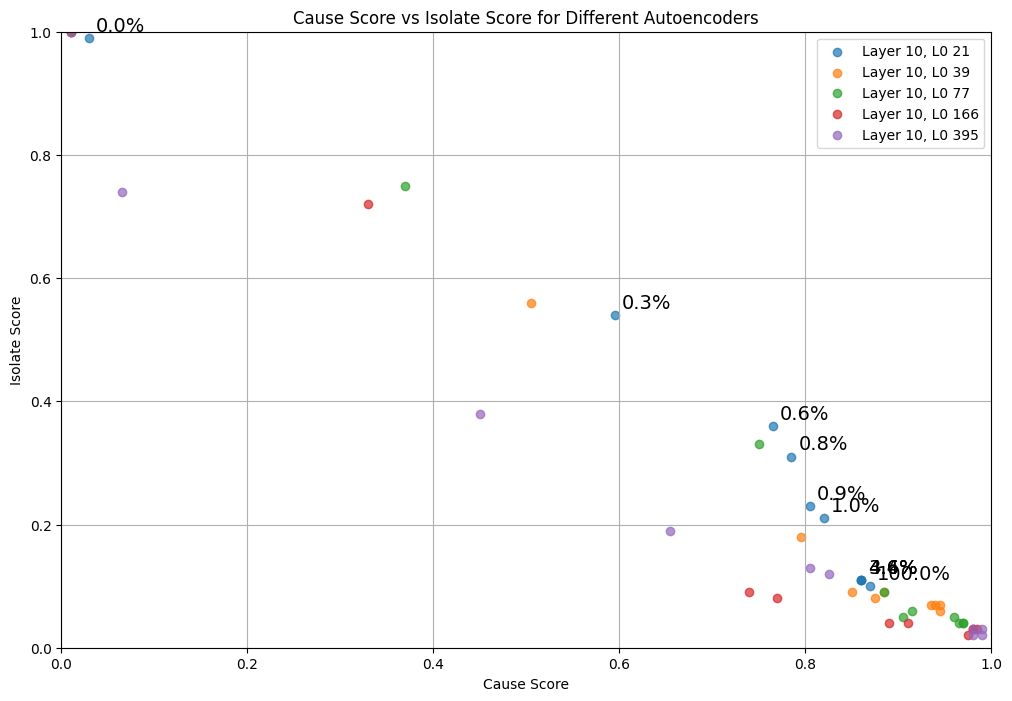

In [7]:
import matplotlib.pyplot as plt

def format_folder_name(folder):
    parts = folder.split('_')
    layer = parts[0].replace('layer', 'Layer ')
    l0 = parts[1].replace('l0', 'L0 ')
    return f"{layer}, {l0}"

# Assuming method_to_data is already populated as described
method = "SAE"  # Since you mentioned there's only one key

# Prepare data for plotting
folders = method_to_data[method].keys()
plot_data = {folder: {'cause': [], 'isolate': [], 'inv_dims': []} for folder in folders}

for folder in folders:
    # if "l021" not in folder:
    #     continue
    for inv_dims, data in method_to_data[method][folder].items():
        plot_data[folder]['cause'].append(data['cause'])
        plot_data[folder]['isolate'].append(data['isolate'])
        plot_data[folder]['inv_dims'].append(inv_dims)

# Create the scatter plot
plt.figure(figsize=(12, 8))

for folder, data in plot_data.items():
    scatter = plt.scatter(data['cause'], data['isolate'], label=format_folder_name(folder), alpha=0.7)
    
    if "l021" not in folder:
        continue

    # Add percentage annotations
    for i, (x, y, inv_dims) in enumerate(zip(data['cause'], data['isolate'], data['inv_dims'])):
        percentage = (inv_dims / 16384) * 100
        plt.annotate(f"{percentage:.1f}%", (x, y), xytext=(5, 5), textcoords='offset points', fontsize=14)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('Cause Score')
plt.ylabel('Isolate Score')
plt.title('Cause Score vs Isolate Score for Different Autoencoders')
plt.legend()
plt.grid(True)


# If you want to save the plot
plt.savefig('cause_vs_isolate_scatter_with_percentages.png')

# If you want to show the plot
plt.show()


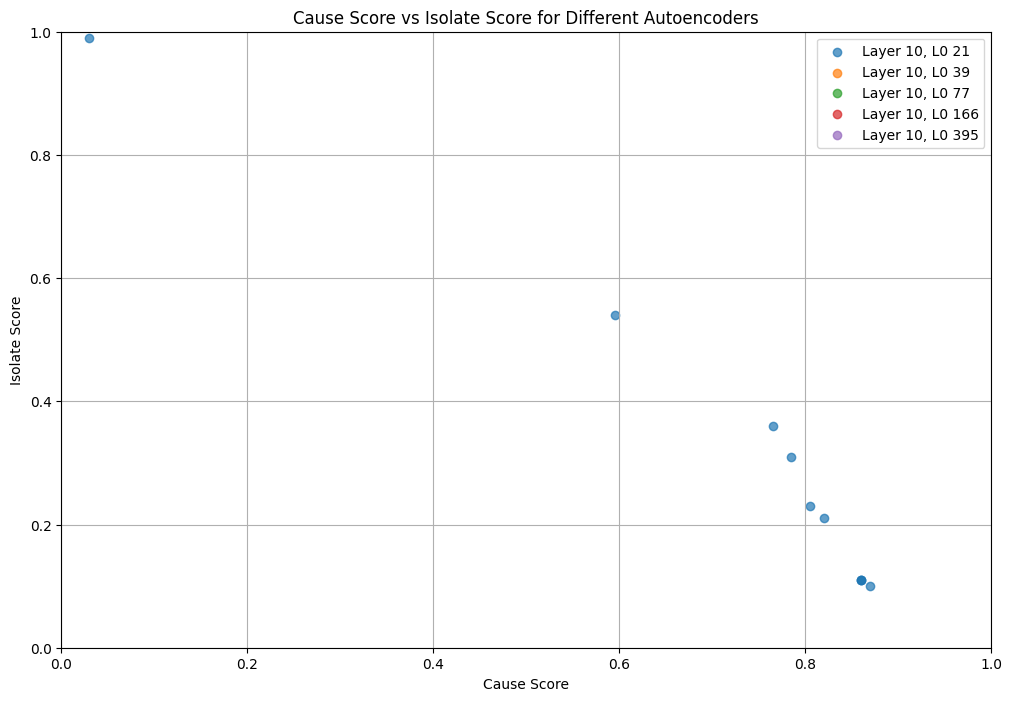

In [5]:
import matplotlib.pyplot as plt

def format_folder_name(folder):
    parts = folder.split('_')
    layer = parts[0].replace('layer', 'Layer ')
    l0 = parts[1].replace('l0', 'L0 ')
    return f"{layer}, {l0}"

# Assuming method_to_data is already populated as described
method = "SAE"  # Since you mentioned there's only one key

# Prepare data for plotting
folders = method_to_data[method].keys()
plot_data = {folder: {'cause': [], 'isolate': []} for folder in folders}

for folder in folders:
    if "l021" not in folder:
        continue
    for data in method_to_data[method][folder].values():
        plot_data[folder]['cause'].append(data['cause'])
        plot_data[folder]['isolate'].append(data['isolate'])

# Create the scatter plot
plt.figure(figsize=(12, 8))

for folder, data in plot_data.items():
    plt.scatter(data['cause'], data['isolate'], label=format_folder_name(folder), alpha=0.7)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('Cause Score')
plt.ylabel('Isolate Score')
plt.title('Cause Score vs Isolate Score for Different Autoencoders')
plt.legend()
plt.grid(True)

# Add a diagonal line
# min_val = min(plt.xlim()[0], plt.ylim()[0])
# max_val = max(plt.xlim()[1], plt.ylim()[1])
# plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)

# If you want to show the plot
plt.show()

# If you want to save the plot
# plt.savefig('cause_vs_isolate_scatter.png')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming method_to_data is defined elsewhere in your code
# method_to_data = defaultdict(<class 'dict'>, {'SAE': {71: {'disentangle': 0.41708333333333336, 'isolate': 0.49666666666666665, 'cause': 0.3375}, 325: {'disentangle': 0.4729166666666667, 'isolate': 0.06333333333333334, 'cause': 0.8825000000000001}, 399: {'disentangle': 0.4741666666666667, 'isolate': 0.05333333333333334, 'cause': 0.895}, 536: {'disentangle': 0.4779166666666667, 'isolate': 0.06333333333333334, 'cause': 0.8925000000000001}, 8192: {'disentangle': 0.47833333333333333, 'isolate': 0.06666666666666667, 'cause': 0.89}}})

# Extract data for SAE method
sae_data = method_to_data['SAE']

# Extract x and y values for each metric
x = list(sae_data.keys())
metrics = ['disentangle', 'isolate', 'cause']
y_values = {metric: [sae_data[key][metric] for key in x] for metric in metrics}

# Create a single plot
plt.figure(figsize=(10, 6))

# Plot each metric
for metric, values in y_values.items():
    plt.plot(x, values, marker='o', label=metric)

# Set plot attributes
plt.title('SAE Metrics')
plt.xlabel('Key')
plt.ylabel('Score')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

KeyError: 'disentangle'